In [1]:
import pandas as pd
import os
import seaborn
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.disable_max_rows() # allow datasets larger than 100k rows

DataTransformerRegistry.enable('default')

In [2]:
# define font sizes
fs_title = 28
fs_axis = 24
fs_tick = 20

# define color schemes
seq_scheme = "plasma"
div_scheme = "purpleorange"
sm_cat_scheme = "category10"
lg_cat_scheme = "category20"
solid_color = "#0f0888"


In [3]:
pb_only = False # SET TO TRUE TO USE ONLY PERSONAL BEST RECORDS

record_df = pd.DataFrame()
if not pb_only:
    # full record dataset
    record_df = pd.read_csv("out/all_records_pt_1.csv", index_col=[0])
    record_df = pd.concat([record_df, pd.read_csv("out/all_records_pt_2.csv", index_col=[0])], ignore_index=True)
else:
    # pb records only
    record_df = pd.read_csv("out/all_pbs.csv", index_col=[0])
    record_df = record_df.reset_index(drop=True)

# full user dataset
user_df = pd.read_csv("out/all_user_info.csv", index_col=[0])
user_df = user_df.reset_index(drop=True)

In [4]:
# construct more attributes
record_df["kps"] = record_df["inputs"] / (record_df["final_time"] / 1000) # keys per second
record_df["kpp"] = record_df["inputs"] / record_df["pieces_placed"] # keys per piece
record_df["percent_perf"] = record_df["finesse_perf"] / record_df["pieces_placed"] # percent of pieces placed with perfect finesse

In [5]:
# calculate time since account creation (users)
def calcTimePlayed(x):
    if x and isinstance(x, str):
        return time.time() - datetime.fromisoformat(x).timestamp()
    else:
        return math.nan
    
user_df["time_played"] = user_df["created_date"].apply(calcTimePlayed) # time since account creation

In [6]:
# sum time of all records per user, convert to minutes
user_df = user_df.merge(record_df.groupby('user_id')['final_time'].sum().apply(lambda x: x / 60000).reset_index().rename(columns={'final_time': 'total_time_played'}), left_on='id', right_on='user_id')
user_df['best_time'] = user_df['best_time'].apply(lambda x: x/1000) # convert to seconds


In [7]:
import gc
del record_df
gc.collect()

40

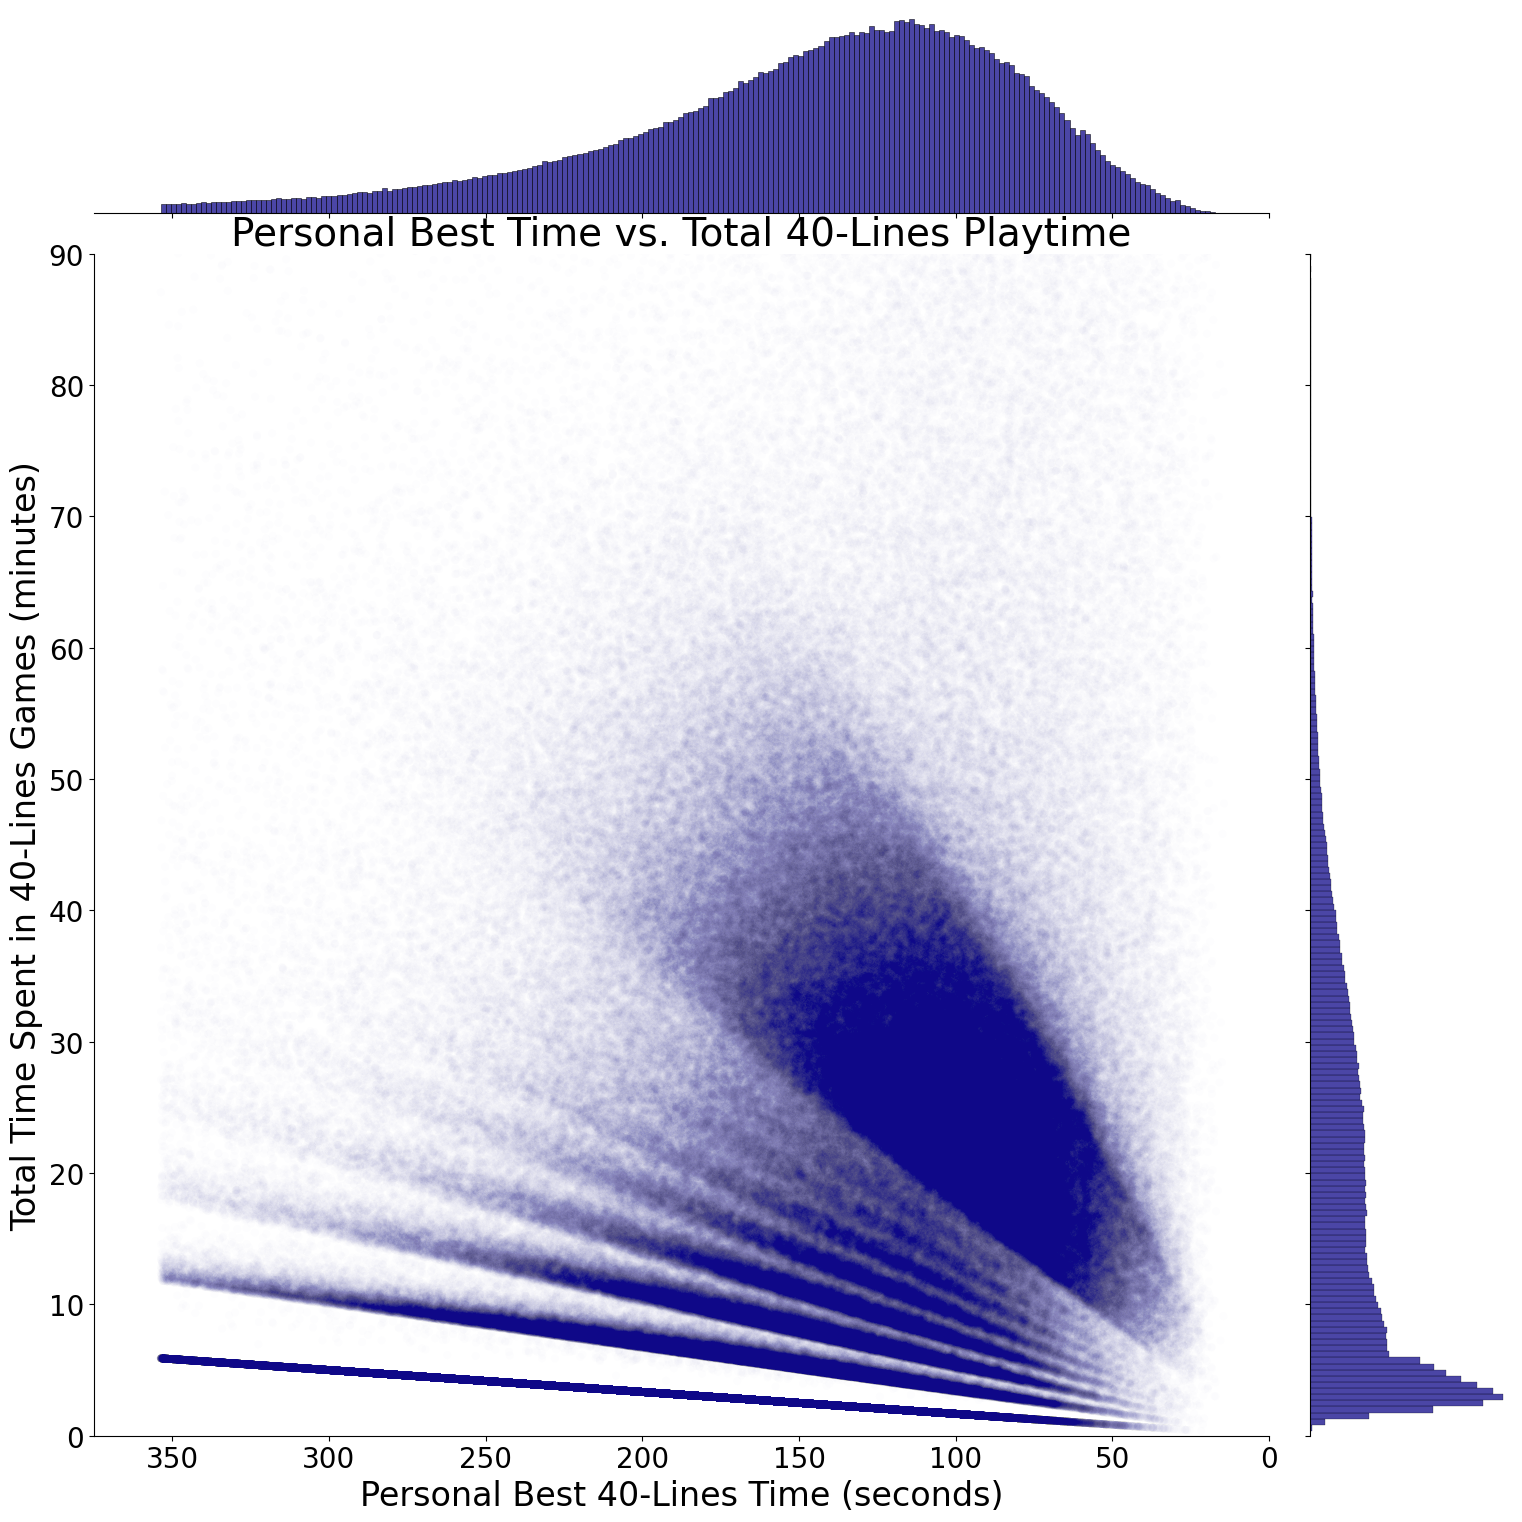

In [8]:
g = seaborn.jointplot(
    x='best_time', y='total_time_played', 
    data=user_df.loc[user_df['total_time_played'] <= 210], 
    kind='scatter',  # Change between 'hex' and 'scatter'
    height=15, 
    color = solid_color,
    alpha = 0.009
    #,gridsize=100  # Decrease to make larger, increase for more granularity
)


g.ax_joint.set_xlim(left=0, right=375)  # right limit of x 
g.ax_joint.set_ylim(bottom=0, top=90)  # upper limit of y
g.ax_joint.collections[0].set_edgecolor('none')

plt.title("Personal Best Time vs. Total 40-Lines Playtime", fontsize=fs_title)
plt.xlabel('Personal Best 40-Lines Time (seconds)', fontsize=fs_axis)
plt.xticks(fontsize=fs_tick)
plt.ylabel('Total Time Spent in 40-Lines Games (minutes)', fontsize=fs_axis)
plt.yticks(fontsize=fs_tick)
plt.gca().invert_xaxis()
plt.show()

In [9]:
# ax = seaborn.kdeplot(
#     x=user_df['best_time'], 
#     y=user_df['num_records'].loc[user_df['num_records'] <= 2000], 
#     cmap=seq_scheme, 
#     fill=True,

# )

# ax.set_ylim(bottom=0, top=50)
# plt.title("Desnsity of Players by Best Time and Number of 40-Lines Games Played")
# plt.xlabel('Personal Best 40-Lines Time (seconds)')
# # plt.xticks(fontsize=fs_tick)
# plt.ylabel('Total Number of 40-Lines Games Played')
# # plt.yticks(fontsize=fs_tick)
# plt.gca().invert_xaxis()
# plt.show()

In [10]:
tmp_user_df = user_df[['best_time', 'total_time_played', 'num_records']].loc[user_df['total_time_played'] <= 90]
tmp_user_df['best_time'] = tmp_user_df['best_time'].apply(lambda x: math.floor(x))
# tmp_user_df['total_time_played'] = tmp_user_df['total_time_played'].apply(lambda x: math.floor(x))

In [ ]:

alt.Chart(tmp_user_df, title="Best Time vs. Total 40-Lines Playtime").mark_rect().encode(
    alt.X('best_time').bin(maxbins=341).axis(title="Personal Best 40-Lines Time (seconds)").scale(reverse=True, domainMax=358, domainMin=8),
    alt.Y('total_time_played').bin(maxbins=341).axis(title="Total Time Spent in 40-Lines Games (minutes)").scale(domainMax=91),
    alt.Color('count():Q', title="Count").scale(scheme=seq_scheme)
).properties(
    height=800,
    width=800
).configure_title(
    fontSize=fs_title
).configure_axis(
    labelFontSize=fs_tick,
    titleFontSize=fs_axis,
    tickMinStep=5,
    labelSeparation=5
).configure_legend(
    labelFontSize=fs_tick,
    titleFontSize=fs_axis,
    labelBaseline='bottom'
)

In [ ]:
alt.Chart(tmp_user_df, title="Best Time vs. 40-Lines Games Played").mark_rect(clip=True).encode(
    alt.X('best_time').bin(maxbins=341).axis(title="Personal Best 40-Lines Time").scale(reverse=True, domainMax=358, domainMin=8),
    alt.Y('num_records').bin(maxbins=341).axis(title="Total Number of 40-Lines Games Played").scale(domainMax=150),
    alt.Color('count():Q', title="Count").scale(scheme=seq_scheme)
).properties(
    height=800,
    width=800
).configure_title(
    fontSize=fs_title
).configure_axis(
    labelFontSize=fs_tick,
    titleFontSize=fs_axis,
    tickMinStep=5,
    labelSeparation=5
).configure_legend(
    labelFontSize=fs_tick,
    titleFontSize=fs_axis
)